<a href="https://colab.research.google.com/github/Guigo1008/btc-price-prediction/blob/main/predicting-btc-ltsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's predict if the prices of Bitcoin will Rise or Fall

## Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from math import sqrt, ceil
from datetime import datetime as dt, timedelta

import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

import pandas_ta as ta
from binance import Client

import csv

%matplotlib inline

## If you have GPU...

In [ ]:
print(tf.config.list_physical_devices('GPU'))
with tf.device('/device:GPU:0'): # All comands indented inside the with will be executed with GPU
    print("Hello World") # If you don't have GPU, it will be executed in your CPU.

[]
Hello World


## Creating the .csv from Binance

In [ ]:
client = Client(None, None)

In [ ]:
# defining the function that fetch the historical data of the wanted coin
def getdata(symbol, period, start, end):
    """
    This function gives us the historical candle data of the desired coin
    :param symbol: coin name that you want to get data
    :param period: time period of candles
    :param start: starting date of candles data
    :param end: end date of candles data
    :return: candles data
    """
    candles = client.get_historical_klines(symbol, period, start, end)
    return candles

# defining the function that make csv file of the historical data of the wanted coin
def make_csv(symbol, candles):
    """
    This function makes csv file of desired coin with defined properties
    :param symbol: coin name that you want to make csv file
    :param candles: historical data of the desired coin
    :return: historical data in csv file
    """
    csvfile = open(symbol + ".csv", "a", newline="")
    cursor = csv.writer(csvfile)
    for i in candles:
        cursor.writerow(i)
    csvfile.close()

    # defining the function that make csv files of the historical data of the wanted multiple coin
def multiple_csv(symbols, interval, start, end):
    """
    This function makes csv file for each coin in symbols parameter with defined properties
    :param symbols: list of multiple coin names that you want to make csv file
    :param interval: time period of candles (default: client.KLINE_INTERVAL_1DAY you can change the interval)
    :param start: starting date of candles data
    :param end: end date of candles data
    :return: historical data of multiple coin in csv files
    """
    for i in symbols:
        make_csv(i, getdata(i, interval, str(start), str(end)))
        print(i, "csv file is ready.")

# defining function the that turn the timestamp to the date
def calculate_time(timestamp):
    """
    This function turns the timestamp to the date
    :param timestamp: given timestamp
    :return: date according to given timestamp
    """
    return dt.fromtimestamp(timestamp/1000)

def obtains_date_today():
    """
    This function fetches today's datetime.
    This way, we can keep our dataset up-to-date.
    Returns:
        Today's datetime, formatted.
    """
    current_date = dt.now()
    formatted_current_date = current_date.strftime("%d %B %Y")
    return formatted_current_date

def create_sequences(data, input_steps, output_steps):
    """
    This function generates sequences that define
    the number of inputs and outputs our model will
    predict. For instance, you can request the model
    to predict the next three days based on the input
    data from the last 60 days.
    Returns:
        Array of X and y, which are ready for splitting.
    """
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)

def prepare_data(scaled_data, test_rate, data):
    """
    This function prepairs our data for the training,

    Returns:
        Array of X and y, which are ready for training.
    """
    train_len = int(len(scaled_data) * (1 - test_rate))

    X_train = np.array([scaled_data[i - 60:i, 0] for i in range(60, train_len)])
    y_train = np.array(data.iloc[60:train_len, :])

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    test_data = scaled_data[train_len - 60:, :]
    X_test = np.array([test_data[i - 60:i, 0] for i in range(60, len(test_data))])
    y_test = np.array(data.iloc[train_len:, :])

    return X_train, y_train, X_test, y_test


In [ ]:
today = obtains_date_today()
# get Bitcoin historical data and make csv
multiple_csv(["BTCUSDT"], client.KLINE_INTERVAL_1DAY, "8 November 2010", today)
headers = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "QAV", "NAT", "TBBAV", "TBQAV", "Ignore"]
data = pd.read_csv("BTCUSDT.csv", names=headers)
data["Open Time"] = data["Open Time"].apply(calculate_time)
data["Close Time"] = data["Close Time"].apply(calculate_time)

BTCUSDT csv file is ready.


In [ ]:
data.tail()

,Open Time,Open,High,Low,Close,Volume,Close Time,QAV,NAT,TBBAV,TBQAV,Ignore
17717,2023-09-05 21:00:00,25792.11,26040.00,25372.51,25759.95,27262.52386,2023-09-06 20:59:59.999,7.007632e+08,636302,12736.70564,3.274164e+08,0
17718,2023-09-06 21:00:00,25759.95,26443.14,25615.38,26255.00,27687.49567,2023-09-07 20:59:59.999,7.189230e+08,631929,13506.19156,3.507413e+08,0
17719,2023-09-07 21:00:00,26255.00,26445.50,25647.26,25910.50,28999.76471,2023-09-08 20:59:59.999,7.541845e+08,646852,14238.89945,3.702368e+08,0
17720,2023-09-08 21:00:00,25910.50,25945.09,25796.64,25901.61,10980.62277,2023-09-09 20:59:59.999,2.841095e+08,359038,5212.44349,1.348634e+08,0
17721,2023-09-09 21:00:00,25901.60,26033.66,25570.57,25841.61,18738.26914,2023-09-10 20:59:59.999,4.835775e+08,489773,8747.51072,2.257529e+08,0


## Visualizing the data

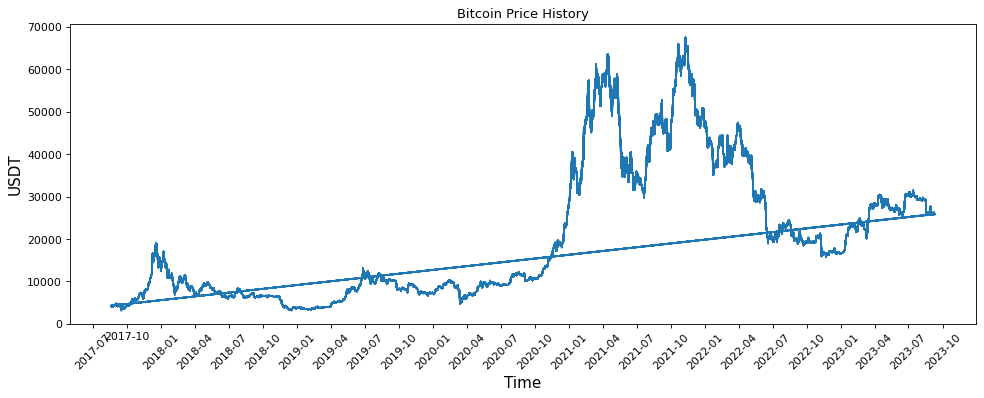

In [ ]:
# Visualize the close price history
plt.figure(figsize=(15,5), dpi=78, edgecolor='b')
plt.title("Bitcoin Price History")
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(data["Close Time"], data["Close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

## Separating data

In [ ]:
# Create new data with only the "Close" column
close = data.filter(["Close"])
# Convert the dataframe to a np array
close_array = close.to_numpy()
# See the train data len
train_close_len = ceil(len(close_array) * 0.8)
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)
X, y = create_sequences(scaled_data, input_steps=60, output_steps=1)
X_train, y_train, X_test, y_test = prepare_data(scaled_data, 0.20, data)

In [ ]:
def model_builder(hp):
    """
    This function create our model.
    We are using keras tuner to search
    for the best hyperparameters.
    Returns:
        Model ready for training.
    """
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))

    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])

    return model

tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 3, executions_per_trial =1,directory = "./")

tuner.search(x=X_train, y=y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test), shuffle=False)

Trial 2 Complete [00h 00m 01s]

Best mse So Far: None
Total elapsed time: 00h 00m 03s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
160               |64                |input_unit
2                 |2                 |n_layers
64                |512               |lstm_0_units
256               |448               |layer_2_neurons
0.4               |0.45              |Dropout_rate
sigmoid           |relu              |dense_activation
224               |32                |lstm_1_units



Traceback (most recent call last):
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/guigo1008/anaconda3/envs/ml/lib/python3.11/site-packages/tensorflow/python/framework/constant_op.py", line 98, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).


In [ ]:
y_train

array([[Timestamp('2017-10-15 22:00:00'), 5710.0, 5788.91, ...,
        719.218538, 4096285.84717841, 0],
       [Timestamp('2017-10-16 22:00:00'), 5760.0, 5774.98, ...,
        688.766779, 3874630.11789208, 0],
       [Timestamp('2017-10-17 22:00:00'), 5595.0, 5596.0, ...,
        1039.622475, 5582555.96464678, 0],
       ...,
       [Timestamp('2020-01-17 21:00:00'), 8913.27, 8988.88, ...,
        19421.295313, 172895403.23974317, 0],
       [Timestamp('2020-01-18 21:00:00'), 8915.09, 9198.98, ...,
        33655.943241, 297282818.0931591, 0],
       [Timestamp('2020-01-19 21:00:00'), 8701.72, 8746.99, ...,
        19453.863782, 168293007.48754647, 0]], dtype=object)

In [ ]:
# Visualize the close price history
plt.figure(figsize=(15,5), dpi=78, edgecolor='b')
plt.title("Bitcoin Price History")
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.plot(data["Close Time"], data["Close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()